# House Prices: Advanced Regression Techniques
### Predict sales prices with detailed feature engineering, automatic outlier detection, Advanced Regression Techniques(GradientBoosting,Xgboost...) and Stacking
![main](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier_files/stacking_cv_algorithm.png)

<br>

**Competition Description**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**Summary**
- 1.Exploratory Data Analysis (EDA):distribution,outliers...
- 2.Personalized Feature Engineering
- 3.Advanced Regression Techniques
- 4.Ensemble Learning



<br>
### Load packages

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [86]:
import numpy as np  
import pandas as pd 
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Ridge 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1.Exploratory Data Analysis (EDA)
### 了解数据的分布：特征工程的基础
* 建议多用describe函数观察特征、target的分布情况
* 画出Correlation matrix、散点图、直方图等

In [90]:
# print(os.listdir("../input"))

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train

print("Train set size:", train.shape)
print("Test set size:", test.shape)
print('start data processing', datetime.now(), )

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Train set size: (1460, 81)
Test set size: (1459, 80)
start data processing 2022-02-17 00:14:14.619495


### 1.1 know your target

In [91]:
# know your target
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/Users/cjzy/python-ws/vms/streamlit-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


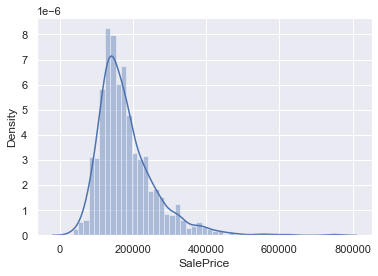

In [92]:
sns.distplot(train['SalePrice']);

In [93]:
#skewness and kurtosis: 可以看到SalePrice的偏度较大，log变换可以缓解这个问题，而且比赛的损失函数也正好是log-rmse，所以随后会对SalePrice作log-transformation
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [94]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#much better
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


### 1.2 Relevance of features-target

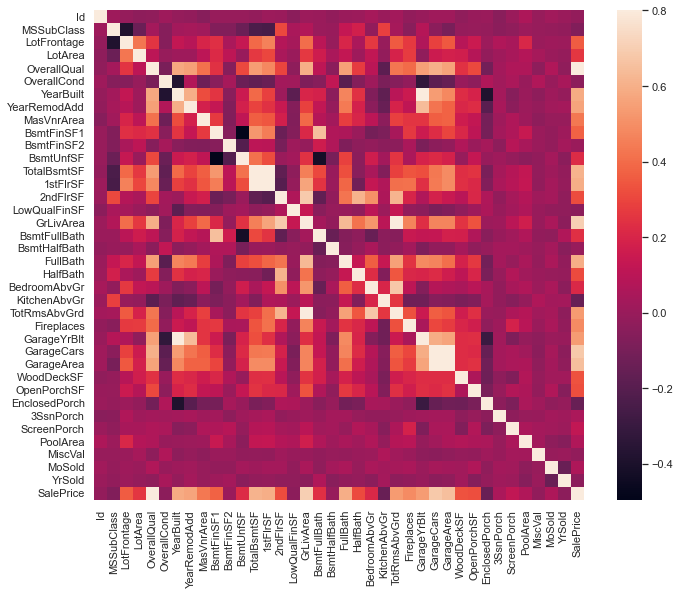

In [95]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [96]:
re_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
train[re_cols]

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd
0,12.247699,7,1710,2,548,856,856,2,2003,2003
1,12.109016,6,1262,2,460,1262,1262,2,1976,1976
2,12.317171,7,1786,2,608,920,920,2,2001,2002
3,11.849405,7,1717,3,642,756,961,1,1915,1970
4,12.429220,8,2198,3,836,1145,1145,2,2000,2000
...,...,...,...,...,...,...,...,...,...,...
1455,12.072547,6,1647,2,460,953,953,2,1999,2000
1456,12.254868,6,2073,2,500,1542,2073,2,1978,1988
1457,12.493133,7,2340,1,252,1152,1188,2,1941,2006
1458,11.864469,5,1078,1,240,1078,1078,1,1950,1996


In [97]:
np.corrcoef(train[re_cols].values.T)

array([[1.        , 0.81718461, 0.70092699, 0.68062487, 0.65088768,
        0.61213423, 0.59698132, 0.59477066, 0.58657019, 0.56560778],
       [0.81718461, 1.        , 0.59300743, 0.60067072, 0.56202176,
        0.5378085 , 0.47622383, 0.55059971, 0.57232277, 0.55068392],
       [0.70092699, 0.59300743, 1.        , 0.46724742, 0.46899748,
        0.4548682 , 0.56602397, 0.63001165, 0.19900971, 0.28738852],
       [0.68062487, 0.60067072, 0.46724742, 1.        , 0.88247541,
        0.43458483, 0.43931681, 0.46967204, 0.53785009, 0.42062215],
       [0.65088768, 0.56202176, 0.46899748, 0.88247541, 1.        ,
        0.48666546, 0.48978165, 0.40565621, 0.47895382, 0.37159981],
       [0.61213423, 0.5378085 , 0.4548682 , 0.43458483, 0.48666546,
        1.        , 0.81952998, 0.32372241, 0.391452  , 0.29106558],
       [0.59698132, 0.47622383, 0.56602397, 0.43931681, 0.48978165,
        0.81952998, 1.        , 0.38063749, 0.28198586, 0.24037927],
       [0.59477066, 0.55059971, 0.6300116

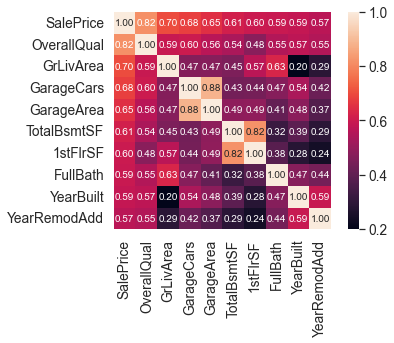

In [98]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 从图中可以看出：

* OverallQual，GrLivArea 以及 TotalBsmtSF  与 SalePrice 有很强的相关性。
* GarageCars 和 GarageArea 也是相关性比较强的变量. 车库中存储的车的数量是由车库的面积决定的，它们就像双胞胎，所以不需要专门区分 GarageCars 和 GarageAre，所以我们只需要其中的一个变量。这里我们选择了 GarageCars，因为它与 SalePrice 的相关性更高一些。
* TotalBsmtSF  和 1stFloor 与上述情况相同，我们选择 TotalBsmtS 。
* FullBath 几乎不需要考虑。
* TotRmsAbvGrd 和 GrLivArea 也是变量中的双胞胎。
* YearBuilt 和 SalePrice 相关性似乎不强。

/Users/cjzy/python-ws/vms/streamlit-env/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


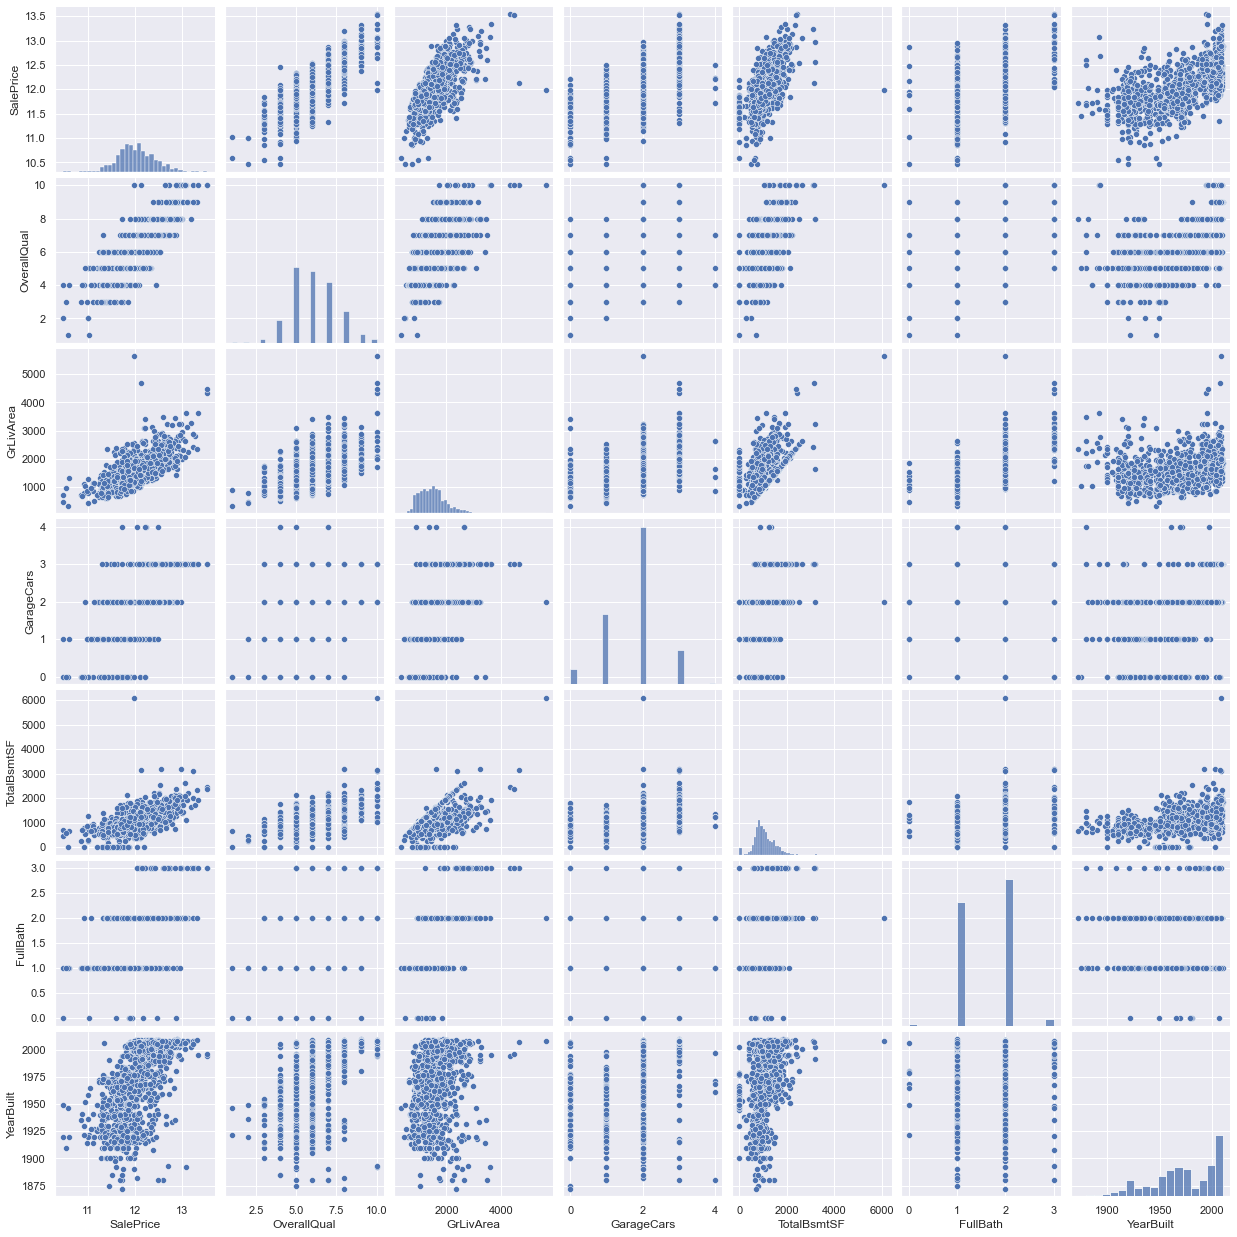

In [99]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()

### 1.3 automatic outlier detecting

In [100]:
def detect_outliers(x, y, top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
    return out_idx

Int64Index([1298, 523, 1182, 691, 533], dtype='int64')

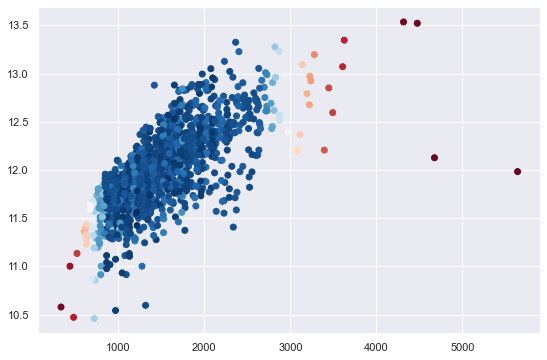

In [101]:
outs = detect_outliers(train['GrLivArea'], train['SalePrice'],top=5) #got 1298,523
outs

In [102]:
lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
x_ = np.array(train['GrLivArea']).reshape(-1, 1)
lof.fit_predict(x_)
lof_scr = lof.negative_outlier_factor_
pd.Series(lof_scr).sort_values()

array([1, 1, 1, ..., 1, 1, 1])

1298   -8.974362
523    -5.968408
1182   -5.366630
691    -4.899521
533    -4.811926
          ...   
136    -0.954031
1404   -0.954031
483    -0.953431
575    -0.953431
339    -0.949657
Length: 1460, dtype: float64

Int64Index([185, 170, 635, 1009, 88], dtype='int64')

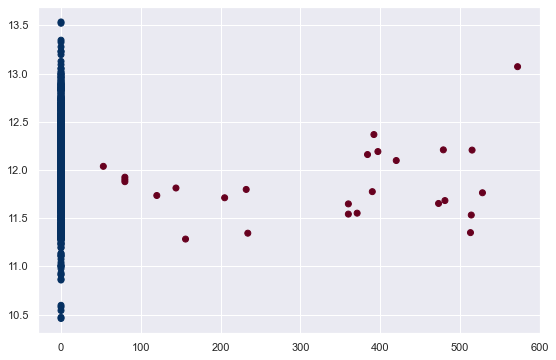

In [103]:
outs = detect_outliers(train['LowQualFinSF'], train['SalePrice'],top=5)#got 88
outs

In [104]:
#很多public kernel中都用这些点，88,523,1298很容易找到，对于其他的outliers后面会补充说明
#改进点８：more or less outliers
outliers = [30, 88, 462, 523, 632, 1298, 1324]

In [105]:
#all_outliers只包含30,88,523,1298，其他的outliers是怎么得到的？
#可能的原因：
#1.detect_outliers函数中的参数设置问题
#2.这里仅从特征与train['SalePrice']的关系来寻找outliers,或许也可以从特征与特征之间的关系来寻找outliers
from collections import Counter
all_outliers=[]
numeric_features = train.dtypes[train.dtypes != 'object'].index
for feature in numeric_features:
    try:
        outs = detect_outliers(train[feature], train['SalePrice'],top=5, plot=False)
    except:
        continue
    all_outliers.extend(outs)

print(Counter(all_outliers).most_common())
for i in outliers:
    if i in all_outliers:
        print(i)

[(0, 4), (533, 4), (1298, 4), (1270, 3), (375, 3), (523, 3), (635, 3), (634, 3), (976, 3), (975, 3), (978, 3), (977, 3), (313, 2), (335, 2), (916, 2), (1213, 2), (812, 2), (77, 2), (7, 2), (953, 2), (496, 2), (1182, 2), (954, 2), (597, 2), (1163, 2), (1350, 2), (1328, 2), (495, 2), (1459, 1), (1, 1), (1458, 1), (1457, 1), (164, 1), (873, 1), (589, 1), (555, 1), (249, 1), (706, 1), (451, 1), (636, 1), (1100, 1), (304, 1), (508, 1), (218, 1), (1442, 1), (1058, 1), (240, 1), (1166, 1), (591, 1), (277, 1), (771, 1), (1140, 1), (1223, 1), (699, 1), (219, 1), (229, 1), (790, 1), (930, 1), (1028, 1), (695, 1), (645, 1), (1149, 1), (125, 1), (599, 1), (574, 1), (332, 1), (440, 1), (1024, 1), (1373, 1), (431, 1), (1400, 1), (185, 1), (170, 1), (1009, 1), (88, 1), (691, 1), (738, 1), (188, 1), (326, 1), (624, 1), (298, 1), (1283, 1), (53, 1), (189, 1), (809, 1), (48, 1), (203, 1), (434, 1), (1218, 1), (642, 1), (166, 1), (309, 1), (605, 1), (1190, 1), (747, 1), (420, 1), (1340, 1), (542, 1), (13

In [106]:
#delete outliers
train = train.drop(train.index[outliers])
train.shape

(1453, 81)

### 1.4 concat train and test

In [107]:
#合并train,test的特征，便于统一进行特征工程
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
features.drop(['Id'], axis=1, inplace=True)
print(features.shape)

(2912, 79)


## 2.feature engineering

In [108]:
#2.1 一些特征其被表示成数值特征缺乏意义，例如年份还有类别(有些类别使用数字表示，会被误认为是数值变量)，这里将其转换为字符串，即类别型变量
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
# 改进点1：OverallQual，OverallCond也是由数字表示的类别变量，但内含顺序信息
# features['OverallQual'] = features['OverallQual'].astype(str)
# features['OverallCond'] = features['OverallCond'].astype(str)

In [109]:
#2.2 numeric_features and 
numeric_features = features.dtypes[features.dtypes != 'object'].index
numeric_features
len(numeric_features) #33
category_features = features.dtypes[features.dtypes == 'object'].index
category_features
len(category_features) #46

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

33

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

46

In [110]:
#2.3 special features with NA---> NO such feature（NA不是真正的缺失值，而是该样本没有这个特征)
special_features = [
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence'
]
len(special_features)

12

### 2.4 fill missing values: 先特殊再一般
### 一般情况：
* numeric_features: 一般填充均值，对于其中的special_features，填0
* category_features: 一般填充众数，少数可以填充中位数等

### 特殊情况：
* Functional,Electrical,KitchenQual具有典型值，应填充典型值
* MSZoning要按MSSubClass分组填充众数
* LotFrontage按Neighborhood分组填充中位数(房子到街道的距离先按照地理位置分组再填充各自的中位数)

In [119]:
features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


23      RM
33      RL
44      RL
61      RL
80      RM
        ..
2692    RL
2705    FV
2846    RM
2887    RM
2888    RM
Name: 120, Length: 182, dtype: object
2811    RL
Name: 150, dtype: object
55      FV
86      FV
113     FV
143     RM
170     RL
        ..
2903    RM
2905    RM
2906    RM
2907    RM
2908    RM
Name: 160, Length: 128, dtype: object
74      RM
432     RM
469     RM
486     RM
610     RM
644     RM
1034    RM
1292    RM
1442    RM
1445    RM
1883    RM
2236    RM
2237    RM
2543    RM
2595    RM
2857    RM
2902    RM
Name: 180, dtype: object
9            RL
47           RM
91      C (all)
123          RM
163          RL
         ...   
2764         RL
2771         RM
2776         RM
2867         RH
2885    C (all)
Name: 190, Length: 61, dtype: object
1       RL
6       RL
10      RL
12      RL
13      RL
        ..
2896    RL
2897    RL
2900    RL
2904    RL
2909    RL
Name: 20, Length: 1076, dtype: object
29           RM
67           RM
90           RL
96           R

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2907   NaN
2908   NaN
2909   NaN
2910   NaN
2911   NaN
Name: MSZoning, Length: 2912, dtype: float64

In [111]:
#1.类别型特征，但明说了具有典型值的：fillna with Typical values
features['Functional'] = features['Functional'].fillna('Typ') #Typ	Typical Functionality
features['Electrical'] = features['Electrical'].fillna("SBrkr") #SBrkr	Standard Circuit Breakers & Romex
features['KitchenQual'] = features['KitchenQual'].fillna("TA") #TA	Typical/Average

#2.分组填充
#groupby：Group DataFrame or Series using a mapper or by a Series of columns.
#transform是与groupby（pandas中最有用的操作之一）组合使用的,恢复维度
#对MSZoning按MSSubClass分组填充众数
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
#对LotFrontage按Neighborhood分组填充中位数(房子到街道的距离先按照地理位置分组再填充各自的中位数)
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#3. fillna with new type: ‘None’(或者其他不会和已有类名重复的str）
features["PoolQC"] = features["PoolQC"].fillna("None") #note "None" is a str, (NA	No Pool)
#车库相关的类别变量，使用新类别字符串'None'填充空值。
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
#地下室相关的类别变量，使用字符串'None'填充空值。
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

#4. fillna with 0: 数值型的特殊变量
#车库相关的数值型变量，使用0填充空值。
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

#5.填充众数
#对于列名为'Exterior1st'、'Exterior2nd'、'SaleType'的特征列，使用列中的众数填充空值。
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

#6. 统一填充剩余的数值特征和类别特征
features[numeric_features] = features[numeric_features].apply(
            lambda x: x.fillna(0)) #改进点2：没做标准化，这里把0换成均值更好吧？
features[category_features] = features[category_features].apply(
            lambda x: x.fillna('None')) #改进点3：可以考虑将新类别'None'换成众数

In [67]:
#2.5 data transformation
#数字型数据列偏度校正
#使用skew()方法，计算所有整型和浮点型数据列中，数据分布的偏度（skewness）。
#偏度是统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。亦称偏态、偏态系数。 
skew_features = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

#改进点5：调整阈值，原文以0.5作为基准，统计偏度超过此数值的高偏度分布数据列，获取这些数据列的index
high_skew = skew_features[skew_features > 0.15]
skew_index = high_skew.index

#对高偏度数据进行处理，将其转化为正态分布
#Box和Cox提出的变换可以使线性回归模型满足线性性、独立性、方差齐次以及正态性的同时，又不丢失信息
#也可以使用简单的log变换
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/Users/cjzy/python-ws/vms/streamlit-env/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cjzy/python-ws/vms/streamlit-env/lib/python3.8/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [68]:
#2.6 特征删除和融合创建新特征
#features['Utilities'].describe()
#Utilities: all values are the same(AllPub 2914/2915)
#Street: Pave 2905/2917
#PoolQC: too many missing values, del_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu'] missing>50%
#改进点4：删除更多特征del_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1) 
#features = features.drop(['Utilities', 'Street', 'PoolQC','MiscFeature', 'Alley', 'Fence'], axis=1) #FireplaceQu建议保留

#融合多个特征，生成新特征
#改进点6：可以尝试组合出更多的特征
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

#简化特征。对于某些分布单调（比如100个数据中有99个的数值是0.9，另1个是0.1）的数字型数据列，进行01取值处理。
#PoolArea: unique      13, top          0, freq      2905/2917
#2ndFlrSF: unique      633, top          0, freq      1668/2917
#2ndFlrSF: unique      5, top          0, freq      1420/2917
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [69]:
#2.7 get_dummies
print("before get_dummies:",features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print("after get_dummies:",final_features.shape)

X = final_features.iloc[:len(y), :]	
X_sub = final_features.iloc[len(y):, :]
print("after get_dummies, the dataset size:",'X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

before get_dummies: (2912, 86)
after get_dummies: (2912, 333)
after get_dummies, the dataset size: X (1453, 333) y (1453,) X_sub (1459, 333)


In [70]:
#2.8 #删除取值过于单一（比如某个值出现了99%以上）的特征
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94: #改进点7：99.94是可以调整的，80,90,95，99...
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = np.array(X.drop(overfit, axis=1).copy())
y = np.array(y)
X_sub = np.array(X_sub.drop(overfit, axis=1).copy())

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

print('feature engineering finished!', datetime.now())

X (1453, 331) y (1453,) X_sub (1459, 331)
feature engineering finished! 2022-02-15 23:07:31.878107


In [72]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


#定义均方根对数误差（Root Mean Squared Logarithmic Error ，RMSLE）
def rmsle(y, y_pred):
    return np.sqrt(mse(y, y_pred))

#创建模型评分函数
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

## 3. Advanced Regression Techniques

In [73]:
#3.1 parameters(for grid search)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

### single model

In [74]:
#3.2 single model
#改进点9:more models
#改进点10: 对svr，GradientBoostingRegressor，LGBMRegressor，XGBRegressor等做GridSearchCV
#ridge
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

#lasso
lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

#elastic net
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

#svm
svr = make_pipeline(RobustScaler(), SVR(
    C=20,
    epsilon=0.008,
    gamma=0.0003,
))

#GradientBoosting（展开到一阶导数）
gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.05,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

#lightgbm
lightgbm = LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
    #min_data_in_leaf=2,
    #min_sum_hessian_in_leaf=11
)

#xgboost（展开到二阶导数）
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3460,
                       max_depth=3,
                       min_child_weight=0,
                       gamma=0,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006)

### ensemble:
* 先对单模型做stacking模型
* 再对单模型+stacking做一次linear blending

In [77]:
#3.3 stacking
#StackingCVRegressor：A 'Stacking Cross-Validation' regressor for scikit-learn estimators.
#regressors=(...)中并没有纳入前面的svr模型,似乎纳入svr之后性能反而变差(why?)：stacking模型的性能0.11748--->0.11873
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [75]:
#3.4 观察单模型的效果
print('TEST score on CV')

score = cv_rmse(ridge) #cross_val_score(RidgeCV(alphas),X, y) 外层k-fold交叉验证, 每次调用modelCV.fit时内部也会进行k-fold交叉验证
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), ) #0.1024

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), ) #0.1031

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )#0.1031 

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), ) #0.1023

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )#0.1061

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )#0.1072

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), ) #0.1064

TEST score on CV
Ridge score: 0.1024 (0.0144)
 2022-02-15 23:12:55.984390
Lasso score: 0.1031 (0.0148)
 2022-02-15 23:13:02.979967
ElasticNet score: 0.1032 (0.0149)
 2022-02-15 23:13:30.406726
SVR score: 0.1024 (0.0133)
 2022-02-15 23:13:33.871615
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsam

In [78]:
#3.5 train the stacking model
#stacking 3步走(可不用管细节，fit会完成stacking的整个流程)：
#1.1 learn first-level model
#1.2 construct a training set for second-level model
#2. train the second-level model:学习第2层的模型，也就是学习如何融合第1层的模型
#3. re-learn first-level model on the entire train set
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(X, y) #Fit ensemble regressors and the meta-regressor.

START Fit
2022-02-15 23:17:58.980374 StackingCVRegressor
[23:19:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be i

## 4. submit

In [79]:
#4.1 submit stacking result
print('Predict submission', datetime.now(),)
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(stack_gen_model.predict(X_sub)))
submission.head()
submission.to_csv("submission_stacking.csv", index=False) #0.11674

Predict submission 2022-02-15 23:22:23.069195


,Id,SalePrice
0,1461,124432.0
1,1462,160805.0
2,1463,183601.0
3,1464,200565.0
4,1465,184108.0


### linear blending

In [80]:
#4.1 在整个训练集上重新训练第1层的单模型和svr，后面blending用(如果直接拿stacking第1层的模型，会报not fit的错误)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(ridge_model_full_data)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)

2022-02-15 23:22:42.693570 ridge
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=10, random_state=42, shuffle=True)))])
2022-02-15 23:22:43.729193 lasso
2022-02-15 23:22:44.424685 elasticnet
2022-02-15 23:22:47.362949 GradientBoosting
2022-02-15 23:22:58.848259 xgboost
[23:22:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
2022-02-15 23:23:07.186714 lightgbm
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
2022-02-15 2

In [81]:
#待混合的models
models = [
    ridge_model_full_data, lasso_model_full_data, elastic_model_full_data,
    gbr_model_full_data, xgb_model_full_data, lgb_model_full_data,
    svr_model_full_data, stack_gen_model
]
len(models)

8

In [82]:
#linear blending coefficients: public coefs
#order: ridge, lasso, elasticnet, gbr, xgboost, lightgbm, svr, stack
public_coefs = [0.1, 0.1, 0.1, 0.1, 0.15, 0.1, 0.1, 0.25]
bias = 0

In [83]:
def linear_blend_models_predict(data_x,models,coefs, bias):
    tmp=[model.predict(data_x) for model in models]
    tmp = [c*d for c,d in zip(coefs,tmp)]
    pres=np.array(tmp).swapaxes(0,1) #numpy中的reshape不能用于交换维度，一开始的种种问题，皆由此来
    pres=np.sum(pres,axis=1)
    return pres

In [85]:
#4.2 submit blend_models_with_public_coefs 

print('blending models RMSLE score on train data:')
print(rmsle(y, linear_blend_models_predict(X,models,public_coefs, bias)))

#before Blend with Top Kernals submissions
print('Predict submission', datetime.now(),)
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(linear_blend_models_predict(X_sub,models,public_coefs, bias))) #expm1: exp(x) - 1; 注意还要取整
# submission.iloc[:,1] = np.expm1(blend_models_predict(X_sub)) 
submission.head()
submission.to_csv("submission_blend_models_with_public_coefs.csv", index=False) #0.11413

blending models RMSLE score on train data:
0.059979882296702224
Predict submission 2022-02-15 23:26:12.193325


,Id,SalePrice
0,1461,122631.0
1,1462,159095.0
2,1463,186039.0
3,1464,199383.0
4,1465,188058.0


In [38]:
#linear blending coefficients: coefs got by linear regression 
#注意：这里很容易过拟合，所以alphas3的不宜过小
#alphas3 = np.linspace(0,1e3,1001) #如果从０开始，RidgeCV会选择０，train_rmse:0.027818，但test_rmse会很大，即过拟合！
#改进点11：如何得到更合适的系数
alphas3 = [70] #可以继续优化，使train_rmse与public_coefs的结果接近

def blend_models(train_x, train_y, models):
    tmp = [model.predict(train_x) for model in models]
    pres = np.array(tmp).swapaxes(0,1) #一开始用的reshape，注意这与pytorch中不同，不能用于多维的维度间的交换！！！
    print(pres.shape)  #(1457,8)
    #注意要设置fit_intercept=False，否则bias会很大，占主导地位，而系数coef_都很小
    #fit_intercept=False时不求截距，但要求数据提前中心化，并且此时会忽略normalize参数
    #linear = LinearRegression(fit_intercept=False)
    linear = RidgeCV(alphas=alphas3,
                     cv=kfolds,
                     fit_intercept=False,
                     scoring=make_scorer(rmsle, greater_is_better=False)
                    )
    linear = linear.fit(pres, train_y)
    print('linear coefficient:')
    print(linear.coef_)
    print('linear bias:')
    print(linear.intercept_)
    print('best alpha: %f'%(linear.alpha_))
    print('best score: %f'%(rmsle(linear.predict(pres), train_y)))
    return linear.coef_, linear.intercept_

In [39]:
#可以对coefs归一化
coefs, bias = blend_models(X, y, models)
sum(coefs)
# coefs=[i/sum(coefs) for i in coefs.tolist()]
# coefs
# from scipy.special import softmax
# coefs=softmax(coefs)
# coefs

(1453, 8)
linear coefficient:
[0.0989877  0.09333764 0.0931413  0.16515319 0.15340795 0.12469782
 0.11161573 0.1595441 ]
linear bias:
0.0
best alpha: 70.000000
best score: 0.059556


0.9998854365116636

In [40]:
#4.3 submit blend_models_with_regression_coefs 
print('blending models RMSLE score on train data:')
print(rmsle(y, linear_blend_models_predict(X,models,coefs,bias))) #0.059305

#before Blend with Top Kernals submissions
print('Predict submission', datetime.now(),)
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(linear_blend_models_predict(X_sub,models,coefs,bias))) #expm1: exp(x) - 1; 注意还要取整
# submission.iloc[:,1] = np.expm1(blend_models_predict(X_sub)) #expm1: exp(x) - 1; 注意还要取整
submission.head()
submission.to_csv("submission_blend_models_with_regression_coefs.csv", index=False) #0.11492 可以得到相当的效果

blending models RMSLE score on train data:
0.059555631619596955
Predict submission 2019-12-12 06:23:07.727869


,Id,SalePrice
0,1461,122680.0
1,1462,159216.0
2,1463,185309.0
3,1464,199283.0
4,1465,187319.0


In [41]:
#4.4 mixing with the top kernels

print('Blend with Top Kernals submissions', datetime.now(),)
sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(linear_blend_models_predict(X_sub,models,public_coefs, bias)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))  
submission.to_csv("submission_blend_top.csv", index=False) #0.11115
print('Save submission', datetime.now())

Blend with Top Kernals submissions 2019-12-12 06:23:09.365169
Save submission 2019-12-12 06:23:11.018272


In [42]:
#4.5 Brutal approach to deal with predictions close to outer range 
#第超低的房价更低，让超高的房价更高(通常来说，会将小者放大，大者缩小，但房价有其特殊性：有些偏远地区的房子比预测更低，
#有些房子比预测高得多)，这里让这两种极端情况更极端一些，这样更符合房价的特性
#注意缩放的分位数0.005,0.995以及缩放系数0.77,1.1可以适当调整，相关public kernel中并未提到这块儿的参数如何选择，猜测：唯结果论
q1 = submission['SalePrice'].quantile(0.0045) 
q2 = submission['SalePrice'].quantile(0.998)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("submission_blend_top_Scale extremes.csv", index=False) #0.10647(best result)
print('Save submission', datetime.now())

Save submission 2019-12-12 06:23:11.048593


In [43]:
submission = pd.read_csv('../input/house-price-best/submission_best.csv')
submission.to_csv("submission_best.csv", index=False) #0.10647(best result)
print('Save submission best', datetime.now())

Save submission best 2019-12-12 06:23:11.075653


## 5.Q & A

### 5.1 有必要重新训练一遍第一层的模型吗？在训练stacking时的3步中应该是包含了这一步的
由下面的代码可见，**训练完stacking之后，如果要与各个单模型做blending,确实有必要再重新训练第1层的模型**

In [44]:
#如果不重新训练每个单模型(跳过4.1)，直接拿stack_gen_model.regressors来用，会发现：
#只有第一个模型能直接predict，其他模型会报not fit错误
stack_gen_model.regressors[0].predict(X)
#stack_gen_model.regressors[1].predict(X) #error
#stack_gen_model.regressors[2].predict(X) #error

array([12.2291767 , 12.19272327, 12.27214818, ..., 12.46645445,
       11.85934606, 11.9406427 ])

### 5.2 detect outliers
* outliers一般可以通过散点图观察而得
* 可以通过LocalOutlierFactor自动检测，详见前面的detect_outliers函数

但很多public kernels中的outliers=outliers = [30, 88, 462, 523, 632, 1298, 1324],有些很容易找到，剩下的完全不知道哪儿来的！！

### 5.3 GridSearchCV

In [45]:
#how to optimize hyperparameters?
# from pactools.grid_search import GridSearchCVProgressBar #if u need progress bar
# def grid_search(model, parameters, train_x, train_y, progress_bar=False, cv=5):
#     #sklearn的0.22版本默认采用5-fold cv，当前版本默认3折
#     models = GridSearchCVProgressBar(
#         model, parameters, cv=cv, verbose=1,
#         n_jobs=6) if progress_bar else GridSearchCV(
#             model, parameters, cv=cv, n_jobs=6)
#     models.fit(train_x, train_y)
#     print(models.best_params_)
#     print(models.best_score_)
#     #print(models.best_estimator_)

# params1 = {
#     'alpha':
#     [0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
# }
# grid_search(Ridge(), params1, X, y, progress_bar=True, cv=5)

### 5.4 Why scale extreme values?
* 一般情况下：小者放大，大者缩小，让极端值尽可能变得正常
* 但房价刚好与之相反：**让极端值更极端！**因为这才是房价！比如有些偏远地区的房子会比预测更低，有些房子比预测高得多

In [46]:
#一般情况下：小者放大，大者缩小，让极端值尽可能变得正常,但不适用于本问题
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*1.1)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*0.77)

submission.to_csv("submission_base_blend_top_Scale extremes2.csv", index=False) #0.11602 反效果
print('Save submission', datetime.now())

Save submission 2019-12-12 06:23:11.152086


### 6.TODO(未竟之事)
时间关系，点到为止！我在前面大概留了10个改进点，有兴趣的朋友可以试试看。

I list about 10 possible improvement points in front, you can try them. (I have tried a few, some may be useful and some may be harmful.)
If anyone have some progress, please feel free to contact me jjgxw@outlook.com
UP! UP! UP!

### 7.Refs
* https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57
* https://www.kaggle.com/zugariy/regression-blending-and-stacking-v-02#3---Removing-outliers
* stacking:https://blog.csdn.net/wstcjf/article/details/77989963 and http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/#api
* xgboost:https://xgboost.readthedocs.io/en/latest/ and https://blog.csdn.net/v_july_v/article/details/81410574
* lightgbm:https://lightgbm.readthedocs.io/en/latest/